###  HAve not changed it for baselines values for the met and p model quite yet

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

windows = True # If on mac put false, windows true

First section is checking that it reconfirms baselines values  

Second section will be running for the end flow values. This will be taken from a new function which stores the values in _storage and we will import

In [3]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines\baselines_met.csv", index_col=0).rename(columns={"Q in single(µm3/s)": "baseline Q"}) # FOR WINDOWS
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines/baselines_met.csv", index_col=0).rename(columns={"Q in single(µm3/s)": "baseline Q"}) # FOR MAC

In [4]:
H = 0.42 #no units,ratio #Hematocrit assumed to be constant
# M_o = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/m #Taken from table 2 from Wiley Payne paper
K_o = 5e-8 #µL/(mm*s*mmHg) #payne paper and boas et al

#convert param to my SU
M_constant = 8.20e-4 # cm3_O2/(cm3*s) , still unsure about the exact conversion so will just input in this section
K = K_o * (10**6) # µm2/(s*mmHg)

hill_constant = 2 # mmHg

In [7]:
# display(baselines)
df = baselines.drop(['Saturation in','Pressure Drop(mmHg)','Saturation out','Saturation ave','partial pressure blood(mmHg)','tissue partials(mmHg)','dS'],axis=1)
df.at[0,'Saturation in'] = 0.94

In [5]:
def check_imag_roots_real(all_roots):
    counter = 0
    sols = 0
    for i in range(len(all_roots)):
        if all_roots[i].imag <= 10e-13 and all_roots[i].imag >= -10e-13:
            sols = all_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols

In [8]:
df['pb-pt'] = M*df['wall thickness(µm)']*df['Vt(µm3)']/(2*np.pi*K*0.5*df['Diameter(µm)']*df['Length(µm)'])

for i in range(len(df)):
    if i != 0:
        df.at[i,'Saturation in'] = df.at[i-1,'Saturation out']
        
    df.at[i,'Saturation out'] = df.at[i,'Saturation in'] - ( (2*np.pi*K*0.5*df.at[i,'Diameter(µm)']*df.at[i,'Length(µm)']) / (df.at[i,'wall thickness(µm)']*cHb*H) ) * df.at[i,'pb-pt'] / df.at[i,'baseline Q']

df['Saturation ave'] = ( df['Saturation in'] + df['Saturation out'] ) / 2 

for j in range(len(df['Saturation ave'])):
        root_temp = None
        sols = 0
        root_temp = np.roots([1,0,150,23400*df.loc[j,'Saturation ave']/(df.loc[j,'Saturation ave']-1)]) #gives mmHg , *133.322
        sols = check_imag_roots_real(root_temp) 
        #sols = sols*133.322 ###Remove this step if want in mmHg
        df.loc[j,'partial pressure blood(mmHg)'] = sols

df['partial pressure tissue(mmHg)'] = df['partial pressure blood(mmHg)'] - df['pb-pt']

# display(df)
# display(baselines)

KeyError: 'M'

# For final flow values

In [5]:
#ss stands for steady state
if windows == True:
    ss = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\steady_state\final_mp_2_99.csv", index_col=0) # FOR WINDOWS
else:
    ss = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/steady_state\final_mp_2_99.csv", index_col=0) # FOR MAC

In [6]:
def check_imag_roots_real(all_roots):
    counter = 0
    sols = 0
    for i in range(len(all_roots)):
        if all_roots[i].imag <= 10e-13 and all_roots[i].imag >= -10e-13:
            sols = all_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols

In [65]:
its = 10
I = [i for i in range(its)]

def create_df():
#     name = pd.DataFrame(ss['Name'])
#     name = pd.DataFrame(columns=I)
#     name = name.set_index('Name')
#     name = pd.concat([name,pd.DataFrame(columns=I)])

    name = pd.DataFrame(np.NaN, index=np.arange(13), columns=I)
    return name
    
M = create_df()
M[0] = [M_constant for i in range(13)]
Sat_in = create_df()
Sat_in.iloc[0,:] = 0.94
Sat_out = create_df()
p_diff = create_df() # pb-pt
Sat_ave = create_df()
pb = create_df()
pt = create_df()

In [66]:

for i in range(its):
    if i!=0:
        M[i] = M_constant*pt[i-1]/(pt[i-1]+hill_constant)
    p_diff[i] = M[i]*ss['wall thickness(µm)']*ss['Vt(µm3)']/(2*np.pi*K*0.5*ss['Diameter(µm)']*ss['Length(µm)'])
    for j in range(len(ss)):
        if j != 0:
            Sat_in.iloc[j,i] = Sat_out.iloc[j-1,i]

        Sat_out.iloc[j,i] = Sat_in.iloc[j,i] - ( (2*np.pi*K*0.5*ss.at[j,'Diameter(µm)']*ss.at[j,'Length(µm)']) / (ss.at[j,'wall thickness(µm)']*cHb*H) ) * p_diff.iloc[j,i] / ss.at[j,'Q(µm3/s)']

    Sat_ave[i] = ( Sat_in[i] + Sat_out[i] ) / 2

    for j in range(len(Sat_ave)):
            root_temp = None
            sols = 0
            root_temp = np.roots([1,0,150,23400*Sat_ave.iloc[j,i]/(Sat_ave.iloc[j,i]-1)]) #gives mmHg , *133.322
            sols = check_imag_roots_real(root_temp) 
            #sols = sols*133.322 ###Remove this step if want in mmHg
            pb.iloc[j,i] = sols

    pt[i] = pb[i] - p_diff[i]
    
    

# display(ss)

In [69]:
view = pd.DataFrame()
num=its-1
view['Name'] = ss['Name']
view['final Saturation in'] = Sat_in[num]
view['-change from baseline Sat in'] = baselines['Saturation in']-view['final Saturation in']
view['final Saturation out'] = Sat_out[num]
view['-change from baseline Sat out'] = baselines.loc[:,'Saturation out']-view['final Saturation out']
view['final pb(mmHg)'] = pb[num]
view['-change from baseline pb(mmHg)'] = baselines.loc[:,'partial pressure blood(mmHg)']-view['final pb(mmHg)']
view['final pt(mmHG)'] = pt[num]
view['-change from baseline pt(mmHg)'] = baselines.loc[:,'tissue partials(mmHg)']-view['final pt(mmHG)']

# view[''] = baselines.loc[:,'']-ss.loc[:,'']

display(view)

# To find out information on what values were used and for how long this was run for etc. 
# just go look at the 1_finak_flows notebook.

,Name,final Saturation in,-change from baseline Sat in,final Saturation out,-change from baseline Sat out,final pb(mmHg),-change from baseline pb(mmHg),final pt(mmHG),-change from baseline pt(mmHg)
0,A1,0.940000,0.000000,0.919610,0.010390,66.937097,1.906034,63.775591,1.903246
1,A2,0.919610,0.010390,0.899230,0.020770,60.894131,4.433667,58.529036,4.428157
2,A3,0.899230,0.020770,0.838317,0.051683,52.776490,7.032573,45.978112,6.994944
3,A4,0.838317,0.051683,0.737581,0.102419,43.173761,9.010219,31.477214,8.854766
4,A5,0.737581,0.102419,0.591630,0.173370,34.534881,10.011845,15.524099,9.170464
5,A6,0.591630,0.173370,0.402592,0.262408,26.740120,10.838892,10.808917,9.577625
6,C,0.402592,0.262408,0.294629,0.315371,21.075912,12.001387,18.407171,11.894608
7,V6,0.294629,0.315371,0.270241,0.327259,18.587725,12.807282,18.120894,12.787260
8,V5,0.270241,0.327259,0.250695,0.336805,17.737920,13.123780,16.617034,13.068137
9,V4,0.250695,0.336805,0.241030,0.341470,17.161732,13.351157,16.527836,13.319076


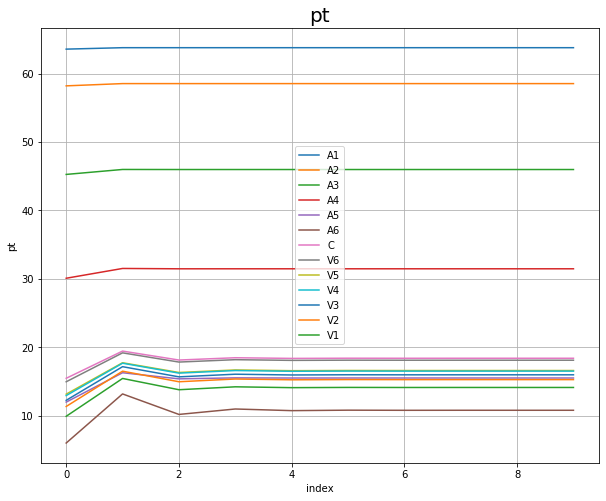

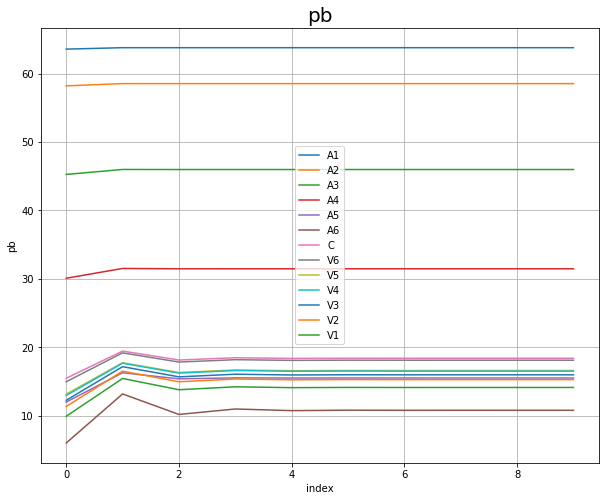

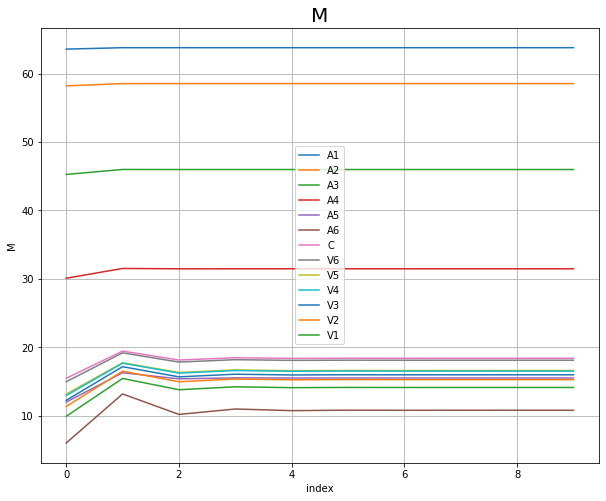

In [68]:
I = [i for i in range(its)]

vessel_names = pd.DataFrame(ss['Name'])
wowza = pd.merge(left=vessel_names, right=pt,left_index=True,right_index=True)
wowza = wowza.set_index('Name')

def plot_parameter(param,name):
    fig,ax = plt.subplots(figsize=(10,8))
    wowza = pd.merge(left=vessel_names, right=pt,left_index=True,right_index=True)
    wowza = wowza.set_index('Name')
    for i in range(param.shape[0]):
#         plt.plot(I,param.iloc[i,:], label=param.index.values[i])
        plt.plot(I,wowza.iloc[i,:], label=wowza.index.values[i])
    ax.legend()
    plt.grid(which='both')
    plt.ylabel('{}' .format(str(name)))
    plt.xlabel('index')
    plt.title('{}' .format(name), fontsize=20)
    
plot_parameter(pt,'pt')
plot_parameter(pb,'pb')
plot_parameter(M,'M')

# fig,ax = plt.subplots(figsize=(10,8))
# plt.plot(I,M)

In [57]:
vessel_names = pd.DataFrame(ss['Name'])
wowza = pd.merge(left=vessel_names, right=pt,left_index=True,right_index=True)
wowza = wowza.set_index('Name')

In [58]:
wowza

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
Name,,,,,,,,,,,,,,,,,,,,,
A1,63.565060,63.776268,63.775589,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,...,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591,63.775591
A2,58.200079,58.530478,58.529030,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,...,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036,58.529036
A3,45.262520,45.986731,45.978018,45.978113,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112,...,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112,45.978112
A4,30.094961,31.525887,31.475668,31.477262,31.477212,31.477214,31.477214,31.477214,31.477214,31.477214,...,31.477214,31.477214,31.477214,31.477214,31.477214,31.477214,31.477214,31.477214,31.477214,31.477214
A5,12.000527,16.291054,15.398871,15.545519,15.520467,15.524714,15.523994,15.524116,15.524095,15.524099,...,15.524098,15.524098,15.524098,15.524098,15.524098,15.524098,15.524098,15.524098,15.524098,15.524098
A6,6.023676,13.196926,10.202888,10.995688,10.755361,10.824278,10.804382,10.810082,10.808451,10.808917,...,10.808813,10.808813,10.808813,10.808813,10.808813,10.808813,10.808813,10.808813,10.808813,10.808813
C,15.480963,19.455892,18.148037,18.483310,18.385676,18.413263,18.405384,18.407628,18.406988,18.407171,...,18.407130,18.407130,18.407130,18.407130,18.407130,18.407130,18.407130,18.407130,18.407130,18.407130
V6,14.972575,19.197201,17.851771,18.199683,18.098629,18.127202,18.119044,18.121368,18.120705,18.120894,...,18.120852,18.120852,18.120852,18.120852,18.120852,18.120852,18.120852,18.120852,18.120852,18.120852
V5,13.163614,17.752644,16.331487,16.700281,16.593487,16.623702,16.615077,16.617535,16.616834,16.617034,...,16.616989,16.616989,16.616989,16.616989,16.616989,16.616989,16.616989,16.616989,16.616989,16.616989
